In [1]:
import gwb as gwb
from gwb import GM as gm

import numpy as np
import ot
import matplotlib.pyplot as plt
from tqdm import trange
import open3d as o3d
import trimesh
import sklearn
from time import time
import lgw

In [2]:
def simplify_mesh_to_n_vertices(mesh,n_vertices):
    sqd = 100 + 2*n_vertices
    while (len(mesh.vertices) > n_vertices):
        mesh = mesh.simplify_quadratic_decimation(sqd)
        sqd = sqd - (len(mesh.vertices) - n_vertices)
    return mesh

# Load FAUST data

In [3]:
#filepath to the FAUST registration meshes
filepath_FAUST = "../data/MPI-FAUST/training/registrations/"

In [4]:
N = 100
n_vertices = 500
meshes = []
for i in range(N):
    filepath = filepath_FAUST + "tr_reg_{0}.ply".format(str("{:03d}".format(i)))
    pcd = o3d.io.read_triangle_mesh(filepath)
    mesh = trimesh.Trimesh(vertices=pcd.vertices,faces = pcd.triangles)
    mesh = simplify_mesh_to_n_vertices(mesh,n_vertices=n_vertices)
    meshes.append(mesh)

# Construct GM spaces

In [5]:
Xs = []
for i in range(N):
    mesh = meshes[i]
    X = gm(X=mesh.vertices,Tris=mesh.faces,mode="surface",gauge_mode="djikstra",squared=False,normalize_gauge=True)#,xi="surface_uniform")
    Xs.append(X)

# Pairwise GW

In [6]:
st = time()
Ps_mat, gw_mat = lgw.pwgw(Xs)
et = time()
time_gw = et - st
print("pw GW in {0} minutes".format(time_gw / 60))

100%|█████████████████████████████████████████| 100/100 [52:15<00:00, 31.36s/it]

pw GW in 52.265900047620136 minutes


## Check Triangle Inequality and Adjust

GW Mat fufills triangle matrix: False
adjusted GW Mat fufills triangle matrix: True
Plot before and after adjusting:


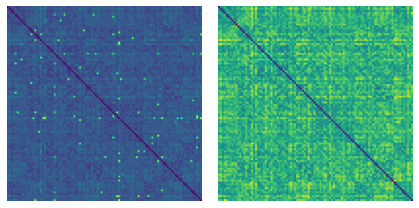

In [7]:
print("GW Mat fufills triangle matrix: {0}".format(lgw.check_triangle_ineq(gw_mat)))
gw_mat_adj, Ps_mat_adj = lgw.adj_gw_mat(Xs,gw_mat,Ps_mat)
print("adjusted GW Mat fufills triangle matrix: {0}".format(lgw.check_triangle_ineq(gw_mat_adj)))

print("Plot before and after adjusting:")
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(gw_mat)
ax[0].axis("off")
ax[1].imshow(gw_mat_adj)
ax[1].axis("off")
plt.tight_layout()
plt.show()

## Plots for Paper

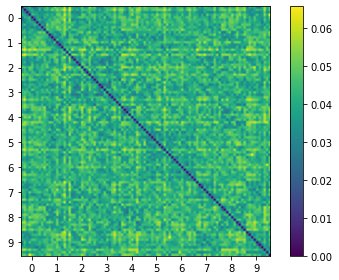

In [8]:
fig, ax = plt.subplots(1,1)
ticks = np.arange(10) * 10 + 4
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_xticklabels(np.arange(10))
ax.set_yticklabels(np.arange(10))
plt.imshow(gw_mat_adj)
plt.colorbar()
plt.tight_layout()
plt.show()

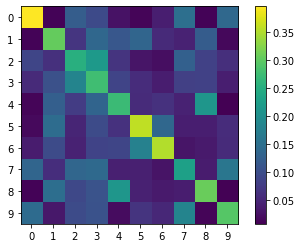

In [9]:
fig, ax = plt.subplots(1,1)

plt.xticks(np.arange(10))
plt.yticks(np.arange(10))

X = np.arange(N)
y = np.concatenate([[i]* 10 for i in range(N//10)])
    
plt.imshow(lgw.conf_mat(gw_mat_adj,X,y))
plt.colorbar()
plt.show()

# Compare with LGW

In [10]:
def lgw_proc(i_init_tb = 0, n_its_tb = 5):
    #TB iterations
    bary = i_init_tb
    lgw_mats = []
    errs_bg = []
    errs_lgw = []
    init_Ps = None
    gwbls = []
    for i in trange(n_its_tb):
        bary_prev = bary
        
        #bary from tb
        idxs, meas, Ps, ref_idx = gwb.tb(bary_prev,Xs,init_Ps=init_Ps)
        bary = gwb.bary_from_tb(Xs,idxs,meas)
        gwbls.append(gwb.gwb_loss(bary_prev,Xs,Ps))
        
        #lgw via barycentric melting
        lgw_mats.append(lgw.LGW_via_idxs(Xs,idxs,meas))
        
    return lgw_mats,gwbls

In [11]:
#k_folds
seed = 0
np.random.seed(seed)

X = np.arange(N)
y = np.concatenate([[i]* 10 for i in range(N//10)])

k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10,random_state=seed,shuffle=True)
k_folds.get_n_splits(X,y)

n_its_tb = 5

accs = []
accs_gw = []
times = []
mres = []
coeffs = []
gwblss = []
gamma = 10

for train_index,test_index in k_folds.split(X,y):
    #get train and test data for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #compute lgw_mat
    i_init_tb = int(np.random.choice(X_train))
    st = time()
    lgw_mats,gwbls = lgw_proc(i_init_tb = i_init_tb,n_its_tb = n_its_tb)
    et = time()
    times.append(et-st)

    gwblss.append(gwbls)
    
    #PCC
    coeff = [np.corrcoef(gw_mat_adj.flatten(),lgw_mats[i].flatten())[0,1] for i in range(n_its_tb)]
    coeffs.append(coeff)

    #MRE
    m_gw = np.ma.masked_equal(gw_mat_adj, 0.0, copy=False)
    m_lgws = [np.ma.masked_equal(lgw_mats[i], 0.0, copy=False) for i in range(n_its_tb)]
    mres.append([np.mean(np.abs(m_gw - m_lgw)/m_gw) for m_lgw in m_lgws])
    
    #GW
    #set up SVM
    kernel_train = np.exp(-gamma*gw_mat_adj[X_train].T[X_train].T)
    svc = sklearn.svm.SVC(kernel="precomputed")
    #fit SVM
    clf = svc.fit(kernel_train, y_train)
    kernel_test = np.exp(-gamma*gw_mat_adj[X_test].T[X_train].T)
    acc = clf.score(kernel_test, y_test)
    accs_gw.append(acc)
    
    #LGW
    #set up SVM with last lgw mat
    accs_per_it = []
    for lgw_mat in lgw_mats:
        #mat = lgw_mats[-1]
        kernel_train = np.exp(-gamma*lgw_mat[X_train].T[X_train].T)
        svc = sklearn.svm.SVC(kernel="precomputed")
        #fit SVM
        clf = svc.fit(kernel_train, y_train)
        kernel_test = np.exp(-gamma*lgw_mat[X_test].T[X_train].T)
        acc = clf.score(kernel_test, y_test)
        accs_per_it.append(acc)
    accs.append(accs_per_it)

100%|█████████████████████████████████████████████| 5/5 [05:00<00:00, 60.09s/it]


In [12]:
print("accs_gw:",accs_gw)
print("mean acc gw",np.mean(accs_gw))
print("std acc gw",np.std(accs_gw))
print("accs:",np.mean(accs,axis=0))
print("std acc",np.std(accs,axis=0))
print("times (mins)",np.array(times)/60)
print("coeffs:",np.array(coeffs))
print("mean coeffs per it", np.mean(coeffs,axis=0))
print("std coeffs per it", np.std(coeffs,axis=0))
print("mres:",np.array(mres))
print("mean mres per it", np.mean(mres,axis=0))
print("std mres per it", np.std(mres,axis=0))

accs_gw: [0.6, 0.5, 0.4, 0.2, 0.3, 0.5, 0.3, 0.6, 0.4, 0.5]
mean acc gw 0.43000000000000005
std acc gw 0.1268857754044952
accs: [0.31 0.41 0.34 0.44 0.39]
std acc [0.08306624 0.14456832 0.12806248 0.12       0.15779734]
times (mins) [4.72115603 4.75980925 4.75189573 4.60705067 4.68165975 4.8653475
 4.7724122  4.72425632 4.79782787 5.00760676]
coeffs: [[0.7019747  0.69150145 0.69280805 0.68844032 0.47484343]
 [0.71337559 0.69240334 0.69878295 0.6862594  0.68707588]
 [0.67252387 0.68431474 0.68911055 0.6829444  0.68969373]
 [0.21308995 0.68074435 0.67934585 0.67839801 0.67487645]
 [0.69632656 0.66170447 0.46146008 0.6771973  0.68437253]
 [0.70836602 0.67918707 0.68558706 0.40079056 0.65552003]
 [0.61356367 0.47213514 0.61733955 0.68679372 0.69031459]
 [0.71337559 0.69240334 0.69878295 0.6862594  0.68707588]
 [0.42996805 0.43527626 0.68151786 0.68386546 0.39464892]
 [0.674042   0.68209827 0.65887197 0.40057138 0.65033394]]
mean coeffs per it [0.6136606  0.63717684 0.65636069 0.627152   0.